### Angular clustering in a series of bins, without cross correlations and free photo-z parameters

Here we further extend the code, such as to include all cross-correlations between redshift bins.

In our forecast we leave as free parameters:

$\bullet$ The cosmological parameters $\Omega_m, \sigma_8$.

$\bullet$ One photometric redshift scatter parameter $\sigma_{z,0}$.

$\bullet$ $N_{bins}$ photometric redshift bias parameters $z_b^i$. 

$\bullet$ $N_{bins}$ galaxy bias factors $b_g^i$.

So, in total, $2N_{bins}$ + 3 parameters.


#### Modeling the Angular power spectrum 

In the Limber approximation (valid for small angles, or $\ell > \sim 20$), we model the angular auto-correlation power spectrum for galaxy clustering as:

\begin{equation}
C_\ell^{ij} = \int \, dz \, \frac{W_i(z) W_j(z) b_i(z)b_j(z) H(z)/c}{\chi^2(z)} P_m\left(z; \frac{\ell + 1/2}{\chi(z)}\right).
\end{equation}

$W_i(z)$ is the radial selection function that encodes the probability of a galaxy to be included in a given bin $i$.
This is the product of the overall (normalized) redshift distribution function of objects $dn/dz$ times a selection function $F_i(z)$ chosen appropriately for each redshift bin:

\begin{equation}
W_i(z) = \frac{\frac{dn}{dz}F_i(z)}{\int_0^\infty \frac{dn}{dz}F_i(z) \,dz}
\end{equation}



For a spectroscopic survey $F_i(z)$ is a top-hat function with limits the limits of each bin. For gaussian photometric uncertainties, the window function becomes:

\begin{equation}
F_i(z) = \frac{1}{2}\left[\mbox{erf}\left(\frac{z - z_{min,i}}{\sqrt{2}\sigma_z} \right) - \mbox{erf}\left(\frac{z - z_{max,i}}{\sqrt{2}\sigma_z} \right)\right] ,
\end{equation}

$z_{min/max,i}$ being the limits of the bin $i$.

The normalized overall redshift distribution can be described by: 

\begin{equation}
\frac{dn}{dz}(z) = \frac{\beta}{z_0^{1+ \alpha}\Gamma\left[\frac{1+\alpha}{\beta}\right]}z^\alpha \exp\left[- \left(\frac{z}{z_0}\right)^\beta \right].
\end{equation}

With $\alpha$ and $\beta$ parameters that describe the shape of the distribution and $z_0$ is related to the median redshift (which means, it has to do with the depth of the survey). 

If the total angular number density of galaxies is 
$\bar{n}^{\,tot}$, the angular number density in a bin $i$ is:

\begin{equation}
\bar{n}^i = \bar{n}^{\, tot}\times \left[\int_0^\infty \frac{dn}{dz}F_i(z) \,dz \right].
\end{equation}

One can check that $\sum_i\bar{n}^i  = \bar{n}^{tot}$.
Let's describe now the other quantities that appear in eqs (1-2).

$b^{i}(z)$ is the galaxy bias in redshift bin $i$. This can be either constant in each bin, or we can assume a form, like $b(z) = b_0/D(z)$, $D(z)$ being the growth factor. In the simple exploration this will be our fiducial model, with $b_0$ free to vary (but if otherwise stated equal to $1.0$).

$\chi(z)$ is the comoving distance, defined as: 

$$
\chi(z) = \int_0^z \, \frac{c}{H(z')}\, dz',
$$

$H(z)$ the Hubble parameter; finally $P_m(z; k)$ is the matter power spectrum at redshift $z$. In linear theory $P_m(z;k) = D^2(z) P_{m,0}(k)$, $P_{m,0}(k)$ being the present day linear power spectrum.

##### Fisher Matrix calculation

### Including cross-correlation

In that case the Fisher matrix is: 

\begin{equation}
F_{\mu \nu} = \frac{f_{sky}}{2} \sum_{\ell} (2\ell + 1)\mbox{Tr}\left(\mathbf{\hat{C}}_\ell^{-1} \mathbf{\hat{C}}_{\ell,\mu} \mathbf{\hat{C}}_\ell^{-1} \mathbf{\hat{C}}_{\ell,\nu} \right)
\end{equation}

with $\mathbf{\hat{C}}_\ell$ being the matrix with elements $\hat{C}_\ell^{ij} = {C}_\ell^{ij} + \delta_{ij}/\bar{n}^i$.





In [34]:
#import stuff
import numpy as np 
import scipy
from scipy.special import erf
from scipy import interpolate 
from scipy.interpolate import UnivariateSpline
import camb
from camb import model, initialpower
from scipy.special import gamma

In [35]:
# Now create a class that can create CAMB cosmologies for different matter densities and sigma_8
class Cosmology:
    
    def __init__(self,omega_m,sigma_8,h,z):
        self.omega_m = omega_m
        self.sigma_8 = sigma_8
        self.h = h
        self.z = z
        self.k_max = 10.0
        self.c = 2.99792e+5
        
        
        #=========================
        
        
        cosmo = camb.CAMBparams()
        cosmo.set_cosmology(H0=100.0*self.h, ombh2=0.048*(self.h**2.0), omch2=(self.omega_m - 0.048)*(self.h**2.0), mnu=0.06, omk=0, tau=0.06)
        cosmo.InitPower.set_params(As=2.0e-9, ns=0.973)
        results = camb.get_results(cosmo)
        cosmo.set_matter_power(redshifts=[0.0], kmax=10.0)
        cambres= camb.get_transfer_functions(cosmo)
        cosmo.NonLinear = model.NonLinear_both
        kh, z, pk = cambres.get_matter_power_spectrum(minkh=1e-3, maxkh=1.0, npoints = 10)
        sigma_8_temp = cambres.get_sigma8()
        As_new  = ((self.sigma_8/sigma_8_temp)**2.0)*(2.0e-9)
        cosmo.InitPower.set_params(As=As_new, ns=0.973)
        cambres = camb.get_results(cosmo)
        backres = camb.get_background(cosmo)

        self.chi = backres.comoving_radial_distance(self.z)
           
        self.PK = camb.get_matter_power_interpolator(cosmo, nonlinear=True, 
                hubble_units=False, k_hunit=False, kmax=self.k_max, zmin = 0.0, zmax=self.z[-1]) 
        
        self.H_z = (backres.hubble_parameter(self.z))/self.c #Hubble parameter in 1/Mpc 
        
        
#===================================================================================================================
#===================================================================================================================

# Selecting cosmologies

# Instantize cosmologies 

omega_m = 0.301
sigma_8 = 0.798
h = 0.682
alpha_om  = omega_m/10.0
alpha_sig = sigma_8/10.0

#==========================
nz = 1000 #number of steps to use for the radial/redshift integration

zarray = np.linspace(0,4.0,nz)
z = zarray[1:-1]

cosmo_fid = Cosmology(omega_m, sigma_8, h, z)
cosmo_1 = Cosmology(omega_m + alpha_om, sigma_8, h, z)
cosmo_2 = Cosmology(omega_m - alpha_om, sigma_8, h, z)
cosmo_3 = Cosmology(omega_m, sigma_8 + alpha_sig, h, z)
cosmo_4 = Cosmology(omega_m, sigma_8 - alpha_sig, h, z)

#=====================================================================================================
#=====================================================================================================

def cosmoselector(omega, sigma):
    #function that selects cosmology
    
    omfid = 0.301
    sigfid = 0.798
    
    cosmo_dict = {'cosmo_fid': cosmo_fid,
                  'cosmo_1' : cosmo_1,
                  'cosmo_2' : cosmo_2,
                  'cosmo_3' : cosmo_3,
                  'cosmo_4' : cosmo_4}
    
    
    if (omega==omfid):
        if (sigma == sigfid):
            cosm_sel = cosmo_dict['cosmo_fid']
        elif (sigma > sigfid):
            cosm_sel = cosmo_dict['cosmo_3']
        else:
            cosm_sel = cosmo_dict['cosmo_4']
    elif (omega > omfid): 
        cosm_sel = cosmo_dict['cosmo_1']
    else:
        cosm_sel = cosmo_dict['cosmo_2']
        
    
    return cosm_sel

In [36]:
# Function that calculates and returns window function W(z) for clustering in a bin i

def W_z_clust(z, dz, z_i, z_f, sig_z, z_b, b_g, z_0, a, b ):
    """
    Function that calculates the window function for 2D galaxy clustering in a bin i
    -----------------
    Inputs:
    z: array of redshifts used to calculate the window function
    dz: array of dz's - useful for the integral
    z_i : lower redshift limit of the bin
    z_f : upper redshift limit of the bin
    sig_z : photometric error spread
    z_b : redshift bias in a bin i 
    b_g : galaxy bias in a bin i
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    The window function and its integral over all redshifts for a given bin with given limits
    
    """
    
    # Overall redshift distribution
    pref = b/(z_0*gamma((a+1.0)/b))
    dNdz = pref*((z/z_0)**a)*np.exp(-(z/z_0)**b)
    
    # Photometric window function
    x_min = (z - z_i - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))
    x_max = (z - z_f - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))
    F_z = 0.5*(erf(x_min) - erf(x_max))
    
    # Normalization
    norm_const = np.dot(dz, dNdz*F_z)
    
    # Window function 
    
    W_z_bin = b_g*dNdz*F_z/norm_const

    return W_z_bin, norm_const 


In [37]:
# Function that calculates C_l,ij  - the cross angular spectum between two bins

def C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m_var, sig_8_var, z_0, a, b):
    """
    Function that calculates the C_l between two bins 
    -----------------
    Inputs:
    z_i_1 : Lower limit of the first bin
    z_f_1 : Upper limit of the first bin
    z_i_2 : Lower limit of the second bin
    z_f_2 : Upper limit of the second bin
    sig_z : photo-z error scatter
    z_b_1 : photo-z bias of the first bin
    z_b_2 : photo-z bias of the second bin
    b_g_1 : galaxy bias of the first bin
    b_g_2 : galaxy bias of the second bin
    Omega_m_var: Omega matter - can change
    sig_8_var : Sigma_8 parameter - can change
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    ls and C_l betwenn two bins, i and j. It is the auto spectrum if i=j
    """
    
    # Constant
    h = 0.682
    c = 2.99792e+5

    #====================================================================================
    #====================================================================================
    # Selecting cosmology
    
    cosmo = cosmoselector(Omega_m_var, sig_8_var)
    
    #====================================================================================
    #====================================================================================
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    #====================================================================================
    #Calculate the window function in the two bins
    
    W_1 = W_z_clust(zarray, dzarray, z_i_1, z_f_1, sig_z, z_b_1, b_g_1,z_0, a, b)[0]
    W_2 = W_z_clust(zarray, dzarray, z_i_2, z_f_2, sig_z, z_b_2, b_g_2,z_0, a, b)[0]
    
    #===================================================================================
    #Calculate Hubble parameter and comoving distance
    Hubble = cosmo.H_z
    # Get comoving distance - in Mpc
    chis = cosmo.chi
    #========================================================
    # Get the full prefactor of the integral
    prefact = W_1*W_2*Hubble/(chis**2.0)
    #===================================================================================
    #===================================================================================
    #Do integral over z
    
    ls_lin = np.linspace(1.0, np.log10(2000.0), 55, dtype = np.float64)
    
    ls = 10.0**ls_lin
    
    c_ell=np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        c_ell[i] = np.dot(dzarray, w*cosmo.PK.P(zarray, k, grid=False)*prefact)
    
    
    #===================================================================================
    # Retrurn the array of C_ell
    
    return ls, c_ell   

In [38]:
# Derivatives with respect to the cosmological parameters - matter density and sigma_8
# ===================================================================================

# First, Derivative with respect to matter density

def matter_der_C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l between two bins, with respect to matter density
    -----------------
    Inputs:
    z_i_1 : Lower limit of the first redshift bin
    z_f_1 : Upper limit of the first redshift bin
    z_i_2 : Lower limit of the second redshift bin
    z_f_2 : Upper limit of the second redshift bin
    sig_z : photo-z error scatter 
    z_b_1 : photo-z bias of the first bin
    z_b_2 : photo-z bias of the second bin
    b_g_1 : galaxy bias of the first bin
    b_g_2 : galaxy bias of the second bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    derivative w/r to matter of C_l between two bins i and j
    """
    alpha_m = Omega_m/10.0
    
    C_mat_1 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m+alpha_m , sig_8, z_0, a, b)[1]
    C_mat_2 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m-alpha_m , sig_8, z_0, a, b)[1]
    
    mat_der = (C_mat_1 - C_mat_2)/(2.0*alpha_m)
    return mat_der

# =========================================================================================
#==========================================================================================
#  Next, Derivative with respect to sigma_8   

def sigma_der_C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l with respect to sigma_8 
    -----------------
    Inputs:
    z_i_1 : Lower limit of the first redshift bin
    z_f_1 : Upper limit of the first redshift bin
    z_i_2 : Lower limit of the second redshift bin
    z_f_2 : Upper limit of the second redshift bin
    sig_z : photo-z error scatter 
    z_b_1 : photo-z bias of the first bin
    z_b_2 : photo-z bias of the second bin
    b_g_1 : galaxy bias of the first bin
    b_g_2 : galaxy bias of the second bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    derivative w/r to sigma_8 between two bins i and j
    """
    
    alpha_s = sig_8/10.0
    
    C_sig_1 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m, sig_8+alpha_s, z_0, a, b)[1]
    C_sig_2 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m , sig_8-alpha_s, z_0, a, b)[1]
    
    sig_der = (C_sig_1 - C_sig_2)/(2.0*alpha_s)
    return sig_der

In [52]:
# In this module I write all the necessary functions used to calculate the derivatives of 
# C_\ell^{ij} w/r to  the photo-z bias parameters z_b^k 
#=========================================================================================
#=========================================================================================
# Simple function to calculate clustering kernel - without the bias

def W_z_clust_simple(z, dz, z_i, z_f, sig_z, z_b, z_0, a, b):
    """
    Function that calculates the window function for 2D galaxy clustering in a bin i
    -----------------
    Inputs:
    z: array of redshifts used to calculate the window function
    dz: array of dz's - useful for the integral
    z_i : lower redshift limit of the bin
    z_f : upper redshift limit of the bin
    sig_z : photometric error spread
    z_b : redshift bias in a bin i 
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    The window function and its integral over all redshifts for a given bin with given limits
    
    """
    # Overall redshift distribution
    pref = b/(z_0*gamma((a+1.0)/b))
    dNdz = pref*((z/z_0)**a)*np.exp(-(z/z_0)**b)
    
    # Photometric window function
    x_min = (z - z_i - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))
    x_max = (z - z_f - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))
    F_z = 0.5*(erf(x_min) - erf(x_max))
    
    # Normalization
    norm_const = np.dot(dz, dNdz*F_z)
    
    # Window function 
    
    W_z_inbin = dNdz*F_z/norm_const

    return W_z_inbin
#===============================================================================================    
#===============================================================================================    
# Derivative of the clustering kernel w/r to the photo-z bias  
def W_z_clust_der(z, dz, z_i, z_f, sig_z, z_b, z_0, a, b ):
    """
    Function that calculates the derviative of the window function for galaxy clustering w/r to photo-z bias
    in a redshift bin
    --------------------------------
    Inputs:
    z: array of redshifts used for the calculations
    dz: array of dz's - useful for the integral
    z_i : lower redshift limit of the bin
    z_f : upper redshift limit of the bin
    sig_z : photometric error spread
    z_b : redshift bias in the bin under consideration 
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    --------------------------------
    Returns:
    derivative of the window function w/r to the photo-z bias in a bin 
    """
    
    # Overall redshift distribution dNdz
    pref = b/(z_0*gamma((a+1.0)/b))
    dNdz = pref*((z/z_0)**a)*np.exp(-(z/z_0)**b)
    
    # Photometric window function
    x_min = (z - z_i - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))
    x_max = (z - z_f - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))
    F_z = 0.5*(erf(x_min) - erf(x_max))
    
    # Derivative of the Photometric window function w/r to photo-z bias
    
    pref_der = 1.0/((1.0+z)*sig_z*np.sqrt(2.0*np.pi))
    exp_max = np.exp(-(x_max**2.0)) 
    exp_min = np.exp(-(x_min**2.0))
    F_z_der = pref_der*(exp_max - exp_min)
    
    # Then we have to calculate two types of integrals, one integral of the photometric window function 
    # and one integral of the derivative of the photometric window function
    
    int_1 = np.dot(dz, dNdz*F_z)
    int_2 = np.dot(dz, dNdz*F_z_der)
    
    # Calculation of the Derivative of the window function 
    
    W_z_der = dNdz*((F_z_der*int_1 - F_z*int_2)/(int_1**2.0))
    
    return W_z_der
  
#===============================================================================================    
#=============================================================================================== 
# Function that calculates the derivative of C_l^{ij} w/r to the redshift bias

def z_bk_der_C_l_ij(z_i_1 ,z_f_1 ,z_i_2, z_f_2, i_bin, j_bin, k_bin, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m, sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l^{ij} with respect to photo_z bias parameter
    ---------------------------------
    Inputs:
    z_i_1, z_f_1 : lower and upper redshift limits of the first photo-z bin
    z_i_2, z_f_2 : lower and upper redshift limits of the second photo-z bin
    i_bin, j_bin, k_bin : indices of the i,j redshift bind and the bias z_b of the k bin, that we are taking the derivative
    sig_z : photo-z error scatter
    z_b_1, z_b_2 : photo-z biases in the
    b_g_1, b_g_2 : galaxy bias factors of the first and second photo-z bins
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------------------------
    Returns:
    derivative w/r to photo_z bias parameter
    """
    # Constants
    
    h = 0.682
    c = 2.99792e+5
    
    #===================================================================================
    # Selecting cosmology
    cosmo = cosmoselector(Omega_m, sig_8)
    #===================================================================================
    #Redshift range for calculations and integration
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dz = (zarray[2:]-zarray[:-2])/2.0
    z = zarray[1:-1]
    
    #==================================================================================
    #==================================================================================
    # \ells for the calculation of the integral
    
    ls_lin = np.linspace(1.0, np.log10(2000.0), 55, dtype = np.float64)
    
    ls = 10.0**ls_lin
    
    #===================================================================================
    #===================================================================================
    #===================================================================================
    
    #First consider the case when none of the bins is the k_bin; then it easy to say that the result is zero
    if ((i_bin != k_bin)and(j_bin != k_bin)):
        
        z_b_der = np.zeros(ls.shape)

        #======================================================================
        # Now consider the case where at least of the bins coincides with bin_k
    else:
        #Define deltas
        if (i_bin == k_bin):
            delta_ik = 1.0
        else:
            delta_ik = 0.0
        
        if (j_bin == k_bin):
            delta_jk = 1.0
        else: 
            delta_jk = 0.0
          
        #==================================================================
        #==================================================================
        # Now get the clustering kernel and its derivative for the two bins
        
        W_i = W_z_clust_simple(z, dz, z_i_1, z_f_1, sig_z, z_b_1, z_0, a, b)
        W_j = W_z_clust_simple(z, dz, z_i_2, z_f_2, sig_z, z_b_2, z_0, a, b)
        
        der_W_i = W_z_clust_der(z, dz, z_i_1, z_f_1, sig_z, z_b_1, z_0, a, b )
        der_W_j = W_z_clust_der(z, dz, z_i_2, z_f_2, sig_z, z_b_2, z_0, a, b )
        
        #And now combine them
        
        in_brack = delta_ik*der_W_i*W_j + delta_jk*der_W_j*W_i
        
        #==================================================================
        #===================================================================
        #Calculate Hubble parameter and comoving distance
        Hubble = cosmo.H_z
        # Get comoving distance - in Mpc
        chis = cosmo.chi
        #===================================================================
        # Get the full prefactor of the integral
        
        prefact = b_g_1*b_g_2*in_brack*Hubble/(chis**2.0)
        
        #===================================================================
        z_b_der =np.zeros(ls.shape)
        w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
        for i, l in enumerate(ls):
            k=(l+0.5)/chis
            w[:]=1
            w[k<1e-4]=0
            w[k>=kmax]=0
            z_b_der[i] = np.dot(dz, w*cosmo.PK.P(z, k, grid=False)*prefact)
    
    #===================================================================================
    # Retrurn the array of the derivative of C_l_ij w/r to z_b 
    
    return z_b_der 
    

In [53]:
# derivative w/r to the photo-z scatter parameter
#==============================================================================

def sig_z_der_C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l with respect to photo_z scatter between two bins i and j
    -----------------
    Inputs:
     z_i_1 : Lower limit of the first redshift bin
    z_f_1 : Upper limit of the first redshift bin
    z_i_2 : Lower limit of the second redshift bin
    z_f_2 : Upper limit of the second redshift bin
    sig_z : photo-z error scatter
    z_b_1 : photo-z bias of the first bin
    z_b_2 : photo-z bias of the second bin
    b_g_1 : galaxy bias of the first bin
    b_g_2 : galaxy bias of the second bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    derivative w/r to photo_z scatter in a bin i
    """
    
    alpha_sig = 0.01
    
    C_sig_z_1 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z + alpha_sig, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m, sig_8, z_0, a, b)[1]
    C_sig_z_2 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z - alpha_sig, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m , sig_8, z_0, a, b)[1]
    
    sig_z_der = (C_sig_z_1 - C_sig_z_2)/(2.0*alpha_sig)
    return sig_z_der

In [56]:
# Here we define a big function that calculates the Fisher matrix, including all cross-correlations
# ==================================================================================================
def Fisher_calculator(z_init, z_end, N_bins, f_sky, sig_z, N_gal_tot, z_0, a, b):
    """
    Function that calculates the Fisher Matrix for a given number of bins, N_bins, including all
    cross-correlations between them. 
    -------------------------------------------------------------------------
    Inputs:
    z_init : Lower redshift limit
    z_end : Upper redshift limit
    N_bins : Number of bins
    f_sky : fraction of the sky of the survey
    sig_z : redshift error scatter
    
    N_gal_tot : total number of galaxies
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    -------------------------------------------------
    Returns:
    The full fisher matrix including cross-correlations
    """
    #==============================================================================
    #==============================================================================
    #Cosmological parameters 
    Omega_m = 0.301
    sigma_8 = 0.798
    h = 0.682
    
    # Setting up cosmology
    
    cosmo = camb.CAMBparams()
    cosmo.set_cosmology(H0=68.2, ombh2=0.048*(h**2.0), omch2=(Omega_m - 0.048)*(h**2.0), mnu=0.06, omk=0, tau=0.06)
    backres = camb.get_background(cosmo)
    #=============================================================
    #=============================================================
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    #================================================================================
    #================================================================================
    #In this module, find the redshift limits of the bins
    
    delta_z = (z_end - z_init)/N_bins # Width of each bin
    
    z_lims = np.zeros(N_bins+1) #An empty array that will contain the upper and lower limits of the bins
                                #The number of limits is equals the number of bins plus one
    
    # Now populate the array of the redshift limits
    for i in range (0,N_bins+1):
        z_lims[i] = z_init + i*delta_z
        
    #================================================================================
    #================================================================================
    # In this module we create an array with the galaxy biases in each bin
    # We use a common galaxy bias model b(z) = 1.0 + z_m, where $z_m$ is the mean redshift 
    # of the bin, z_m = 0.5*(z_i + z_f), where z_i, z_f the limits of each bin
    
    bias = np.zeros(N_bins) #Create an array that will be populated by the bias factors
                            #Its size is the same as the number of bins
        
    #Now populate the array of galaxy biases
    
    for i in range(N_bins):
        bias[i] = 1.0 + 0.5*(z_lims[i]+z_lims[i+1])
     
    #================================================================================
    #================================================================================
    # Photo-z bias fiducial model
    # Here we adopt a very simple model, where the fiducial value for z_b is zero in all bins
    
    z_b = 0.0
    
    #================================================================================
    #================================================================================
    # In this module we calculate the number of galaxies in every bin.
    # In other words, we split the total number of galaxies to the bins
    # Then we convert to angular number density : galaxies/steradian
    
    # Find normalizations 
    # This array containts the normalizations - or the integrals of the window functions
    
    norm_of_bins = np.zeros(N_bins)
    
    for i in range(N_bins):
        z_i_bin = z_lims[i]
        z_f_bin = z_lims[i+1]
        b_g_i = bias[i]
        
        norm_of_bins[i] = W_z_clust(zarray, dzarray, z_i_bin, z_f_bin, sig_z, z_b, b_g_i , z_0, a, b)[1]
    
    # Overall normalization
    tot_norm = np.sum(norm_of_bins)
        
    #Number of galaxies in every bin - an array
    N_gal_in_bins = (N_gal_tot/tot_norm)*norm_of_bins
        
    #Convert to galaxies/steradian now
    ster = f_sky*(4.0*np.pi)    #converts fraction of the sky to steradians
    #Angilar number density on every bin - array    
    n_bin = N_gal_in_bins/ster
    
    
    #================================================================================
    #================================================================================
    # Now we will create 3D matrices where we are going to store C_l^{ij}, C_l,omega_m^{ij}, C_l,sig_8^{ij}
    # and the derivative w/r to the photo-z scatter parameter C_l, sig_z^{ij}
    
    #Initialize matrices 
    l_size = 55   #Size in \ell - this can change
    
    C_l_matr1 = np.zeros([N_bins,N_bins,l_size])  #Contains C_ell's
    C_l_omeg1 = np.zeros([N_bins,N_bins,l_size])  #Contains the derivatives of C_ell's with respect to matter density
    C_l_sig1  = np.zeros([N_bins,N_bins,l_size])  #Contains the derivatives of C_ell's with respect to sig_8 
    C_l_sig_z1 = np.zeros([N_bins,N_bins,l_size]) #Contains the derivatives of C_ell's with respect to the photo-z scatter
    
    #Now let's populate them - run in all combinations of i, j (the different possible bins)
    #But remember that the matrices are symmetric 
    for i in range(0,N_bins):
        #Limits of the first -i- bin
        z_in_i = z_lims[i]
        z_fin_i = z_lims[i+1]
        #Galaxy bias of the first bin
        b_g_i = bias[i]
        for j in range(i,N_bins):
            #Limits of the second -j-bin
            z_in_j = z_lims[j]
            z_fin_j = z_lims[j+1]
            #Galaxy bias of the second bin
            b_g_j = bias[j]
            #======================================================
            if (i==j):
                C_l_matr1[i,i,:] = C_l_ij(z_in_i,z_fin_i,z_in_i,z_fin_i, sig_z, z_b, z_b, b_g_i, b_g_i, Omega_m , sigma_8, z_0, a, b)[1]+ (1.0/n_bin[i])
                C_l_omeg1[i,i,:] = matter_der_C_l_ij(z_in_i,z_fin_i,z_in_i,z_fin_i, sig_z, z_b, z_b, b_g_i, b_g_i, Omega_m , sigma_8, z_0, a, b)
                C_l_sig1[i,i,:] = sigma_der_C_l_ij(z_in_i,z_fin_i,z_in_i,z_fin_i, sig_z, z_b, z_b, b_g_i, b_g_i, Omega_m , sigma_8, z_0, a, b)
                C_l_sig_z1[i,i,:] = sig_z_der_C_l_ij(z_in_i,z_fin_i,z_in_i,z_fin_i, sig_z, z_b, z_b, b_g_i, b_g_i, Omega_m , sigma_8, z_0, a, b)
            else:
                C_l_matr1[i,j,:] = C_l_matr1[j,i,:] = C_l_ij(z_in_i,z_fin_i,z_in_j,z_fin_j, sig_z, z_b, z_b, b_g_i, b_g_j, Omega_m, sigma_8, z_0, a, b)[1]
                C_l_omeg1[i,j,:] = C_l_omeg1[j,i,:] = matter_der_C_l_ij(z_in_i,z_fin_i,z_in_j,z_fin_j, sig_z, z_b, z_b, b_g_i, b_g_j, Omega_m, sigma_8, z_0, a, b)
                C_l_sig1[i,j,:] = C_l_sig1[j,i,:] = sigma_der_C_l_ij(z_in_i, z_fin_i, z_in_j, z_fin_j, sig_z, z_b, z_b, b_g_i, b_g_j, Omega_m, sigma_8, z_0, a, b)  
                C_l_sig_z1[i,j,:] = C_l_sig_z1[j,i,:] = sig_z_der_C_ij(z_in_i, z_fin_i, z_in_j, z_fin_j, sig_z, z_b, z_b, b_g_i, b_g_j, Omega_m, sigma_8, z_0, a, b)  
   
    #=====================================================================================
    #=====================================================================================
    #Create 4D matrix to store C_l,z_b^{ij} (derivatives w/r to the photo-z bias)
   
    C_l_z_b1 = np.zeros([N_bins, N_bins, N_bins, l_size])
    
    for i in range(N_bins):
        #Limits of the first -i- bin
        z_in_i = z_lims[i]
        z_fin_i = z_lims[i+1]
        #Galaxy bias of the first bin
        b_g_i = bias[i]
        for j in range(i,N_bins):
            #Limits of the second -j-bin
            z_in_j = z_lims[j]
            z_fin_j = z_lims[j+1]
            #Galaxy bias of the second bin
            b_g_j = bias[j]
            #============================================================
            for k in range(N_bins):
                
                if (i==j):
                    C_l_z_b1[k,i,i,:] = z_bk_der_C_l_ij(z_in_i ,z_fin_i ,z_in_i, z_fin_i, i, i, k, sig_z, z_b, z_b, b_g_i, b_g_i, Omega_m, sigma_8, z_0, a, b)
                else:
                    C_l_z_b1[k,i,j,:] = C_l_z_b1[k,j,i,:] = z_bk_der_C_l_ij(z_in_i ,z_fin_i ,z_in_j, z_fin_j, i, j, k, sig_z, z_b, z_b, b_g_i, b_g_j, Omega_m, sigma_8, z_0, a, b)
    
    
    #=====================================================================================
    #=====================================================================================
    #=====================================================================================
    # In this module, interpolate and calculate for the whole range in ell
    
    ell_lin = np.linspace(1.0, np.log10(2000.0), 55, dtype = np.float64)
    ls = np.arange(10, 2000, dtype=np.float64)
    
    # First for C_\ell and the derivatives w/r to the cosmological parameters and photo-z scatter 
    C_l_matr = np.zeros([N_bins,N_bins,np.size(ls)])  #Contains C_ell's
    C_l_omeg = np.zeros([N_bins,N_bins,np.size(ls)])  #Contains the derivatives of C_ell's with respect to matter density
    C_l_sig  = np.zeros([N_bins,N_bins,np.size(ls)])  #Contains the derivatives of C_ell's with respect to sig_8 
    C_l_sig_z = np.zeros([N_bins, N_bins,np.size(ls)]) #Contains the derivatives of C_ell's with respect to sig_z
    for i in range(0,N_bins):
        for j in range(i,N_bins):
            l_break = ell_lin[-1]
            for s in range(0,np.size(ls)):
                if (np.sign(C_l_omeg1[i,j,s])>=0.0):
                    l_break = 0.5*(ell_lin[s]+ell_lin[s-1])
                    break
                    
            l_break_scat = ell_lin[-1]
            for s in range(0,np.size(ls)):
                if (np.sign(C_l_omeg1[i,j,s])>=0.0):
                    l_break_scat = 0.5*(ell_lin[s]+ell_lin[s-1])
                    break
            
            C_l_matr_interp  = UnivariateSpline(ell_lin, np.log10(C_l_matr1[i,j,:]+1.0e-20), s=0.0)
            C_omeg_interp = UnivariateSpline(ell_lin, np.log10(abs(C_l_omeg1[i,j,:]+1.0e-20)), s=0.0)
            C_sig_interp = UnivariateSpline(ell_lin, np.log10(C_l_sig1[i,j,:]+1.0e-20), s=0.0)
            C_sig_z_interp = UnivariateSpline(ell_lin, np.log10(abs(C_l_sig_z1[i,j,:]+1.0e-20)), s=0.0)
            for k, l in enumerate(ls):
                ell = np.log10(float(l))
                C_l_matr[i,j,k] = C_l_matr[j,i,k] = 10.0**(C_l_matr_interp(ell))
                C_l_sig[i,j,k] = C_l_sig[j,i,k] = 10.0**(C_sig_interp(ell))
                if (ell < l_break):
                    C_l_omeg[i,j,k] = C_l_omeg[j,i,k] = -(10.0**C_omeg_interp(ell))
                else: 
                    C_l_omeg[i,j,k] = C_l_omeg[j,i,k] = (10.0**C_omeg_interp(ell))
                
                if (ell< l_break_scat):
                    C_l_sig_z[i,j,k] = C_l_sig_z[j,i,k] = -(10.0**C_sig_z_interp(ell))
                else:
                    C_l_sig_z[i,j,k] = C_l_sig_z[j,i,k] = (10.0**C_sig_z_interp(ell))
                    
    #=====================================================================================              
    #Now for the derivatives w/r to the galaxy bias
    # Because of the simple form of the galaxy bias we can directly connect it to the C_l_matr, after the interpolation
    
    C_l_bias = np.zeros([N_bins,N_bins,N_bins,np.size(ls)]) #Matrix to contain the derivatives w/r galaxy bias factors
                                                            #First index --> shows the bin and stores for a different galaxy bias
                                                            # Second, third indices are the ij indices of C_l^{ij}
                                                            # fourth index spans the ells 
    bias_prefact = np.zeros([N_bins,N_bins,N_bins,np.size(ls)]) #Initialize a matrix where we are going  
                                                        #to store the prefactors for the bias integral
    for i in range(N_bins):
        for j in range(N_bins):
            denom = bias[i]*bias[j]
            for k in range(N_bins):
                if (i==k):
                    delta_ik = 1.0
                else:
                    delta_ik = 0.0
                
                if (j==k):
                    delta_jk = 1.0
                else:
                    delta_jk = 0.0
                    
                bias_prefact[k,i,j,:] = (delta_ik*bias[j] + delta_jk*bias[i])/denom
                
                
    for k in range(N_bins):
        C_l_bias[k,:,:,:] = (bias_prefact[k,:,:,:])*C_l_matr
    
    #====================================================================================
    #And the derivatives w/r to the photo-z bias  
    
    #Initialize the matrix 
    C_l_z_b = np.zeros([N_bins, N_bins, N_bins, np.size(ls)]) #Again, as before:
                                                              # First index: 
                                                              # Second, third indices
                                                              # Fourth index: 
                
    for k in range(N_bins):
        for i in range(N_bins):
            for j in range(i,N_bins):
                l_break = ell_lin[-1]
                for s in range(0,np.size(ell_lin)):
                    if (np.sign(C_l_z_b[k,i,j,s])>=0.0):
                        l_break = 0.5*(ell_lin[s]+ell_lin[s-1])
                    break
                
                
                C_l_z_b_interp = UnivariateSpline(ell_lin, np.log10(abs(C_l_z_b1[k,i,j,:]+1.0e-20)), s=0.0)
                
                for k_l, l in enumerate(ls):
                    ell = np.log10(float(l))
                    
                    if (ell < l_break):
                        C_l_z_b[k,i,j,k_l] = C_l_z_b[k,j,i,k_l] = -(10.0**C_l_z_b_interp(ell))
                    else:
                        C_l_z_b[k,i,j,k_l] = C_l_z_b[k,j,i,k_l] = (10.0**C_l_z_b_interp(ell))
    
    #====================================================================================
    #====================================================================================
    # Calculate the l_max
    # Create array of the l_max for each bin
    
    k_cutoff= 0.6*h #Cutoff scale in  Mpc^{-1}
    # Empty array that will contain the l_max of each bin 
    l_max = np.zeros(N_bins+1) 
    #Now populate 
    for i in range(N_bins+1):
        if (i>0): 
            z_low = z_lims[i-1] #Lower redshift limit of the bin
            z_up = z_lims[i] #Upper redshift limit of the bin
            z_mean = 0.5*(z_low + z_up)
            chi_mean = backres.comoving_radial_distance(z_mean) # comoving distance corresponding to the mean redshift of the bin 
            l_max[i] = int(round(k_cutoff*chi_mean))   
        else:
            l_max[i] = 9
            
    #======================================================================================
    #======================================================================================
    #======================================================================================
    # It is time to calculate the elements of the Fisher matrix
    
    # Define the dimensions of the Fisher matrix. Its dimensions are (2*N_bins + 3)*(2*N_bins + 3)
    dim = 2*N_bins + 3
    
    Fish = np.zeros([dim,dim])
    #Labels correspond to:
    # 0 = matter, 1 = sigma_8, 2 = photo_z scatter (common for all bins)
    # 2 + i_bin = photo_z bias in the i-th bin, 2 + N_bins + i_bin = galaxy bias in the i-th bin
    
    for i in range(0, N_bins):
        low_ell = int(l_max[i]) - 9          #lower \ell_limit
        upper_ell = int(l_max[i+1]) - 9       #upper \ell_limit
        #=========================================================================
        # Define the parts of the matrices in the bins under consideration
        ls_loc = ls[low_ell:upper_ell] #ls
        C_l_loc = C_l_matr[i:,i:,low_ell:upper_ell] #  C_l matrix
        C_l_om_loc = C_l_omeg[i:,i:,low_ell:upper_ell] # Omega matter derivative
        C_l_sig_loc = C_l_sig[i:,i:,low_ell:upper_ell] # Sigma_8 derivative
        C_l_sig_z_loc = C_l_sig_z[i:,i:,low_ell:upper_ell] #
        #========================================================================
        #Calculate the inverse of C_l_loc
    
        C_l_inv_loc = np.zeros_like(C_l_loc)
        for k in range(0, np.size(ls_loc)):
            C_l_inv_loc[:,:,k] = np.linalg.inv(C_l_loc[:,:,k])
    
        #========================================================================
        ls_fac = 2.0*ls_loc + 1.0
        #diagonal terms
        Fish[0,0] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_om_loc*C_l_inv_loc*C_l_om_loc))
        Fish[1,1] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_sig_loc*C_l_inv_loc*C_l_sig_loc))
        Fish[2,2] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_sig_z_loc*C_l_inv_loc*C_l_sig_z_loc))
        
        #Non-diagonal terms now 
        Fish[0,1] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_om_loc*C_l_inv_loc*C_l_sig_loc))
        Fish[0,2] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_om_loc*C_l_inv_loc*C_l_sig_z_loc))
        Fish[1,2] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_sig_loc*C_l_inv_loc*C_l_sig_z_loc))
    
        for j in range (N_bins):
            i_bin = j+1 
            
            C_l_bias_loc = C_l_bias[j,i:,i:,low_ell:upper_ell]
            C_l_z_b_loc = C_l_z_b[j,i:,i:,low_ell:upper_ell]
            
            #diagonal terms
            Fish[2+i_bin,2+i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_z_b_loc*C_l_inv_loc*C_l_z_b_loc))
            Fish[2 + N_bins + i_bin,2 + N_bins + i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_bias_loc*C_l_inv_loc*C_l_bias_loc))
            
            #Non-diagonal terms
            
            Fish[0,2 + i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_om_loc*C_l_inv_loc*C_l_z_b_loc))
            Fish[0,2 + N_bins + i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_om_loc*C_l_inv_loc*C_l_bias_loc))
            
            
            Fish[1,2 + i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_sig_loc*C_l_inv_loc*C_l_z_b_loc)) 
            Fish[1,2 + N_bins + i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_sig_loc*C_l_inv_loc*C_l_bias_loc))
            
            Fish[2,2 + i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_sig_z_loc*C_l_inv_loc*C_l_z_b_loc))
            Fish[2,2 + N_bins + i_bin]  += sum(ls_fac*np.trace(C_l_inv_loc*C_l_sig_z_loc*C_l_inv_loc*C_l_bias_loc))
            
            
            Fish[2 + i_bin,2 + N_bins + i_bin] += sum(ls_fac*np.trace(C_l_inv_loc*C_l_z_b_loc*C_l_inv_loc*C_l_bias_loc)) 
     
    
    #=================================================
    Fish[1,0] = Fish[0,1]
    Fish[2,0] = Fish[0,2]
    Fish[2,1] = Fish[1,2]
    
    for j in range (N_bins):
        i_bin = j+1
        
        Fish[2 + i_bin, 0] = Fish[0,2 + i_bin] 
        Fish[2 + N_bins + i_bin, 0] = Fish[0,2 + N_bins + i_bin]
        
        Fish[2 + i_bin, 1] = Fish[1,2 + i_bin]
        Fish[2 + N_bins + i_bin, 1] = Fish[1,2 + N_bins + i_bin]
        
        Fish[2 + i_bin, 2] = Fish[2,2 + i_bin] 
        Fish[2 + N_bins + i_bin, 2] = Fish[2,2 + N_bins + i_bin]
        
        Fish[2 + N_bins + i_bin, 2 + i_bin] = Fish[2 + i_bin,2 + N_bins + i_bin]
        
    
    #=====================================================
    
    Fish = (0.5*f_sky)*Fish
    return Fish
    
    
    

In [57]:
z_init = 0.4
z_final = 0.6
sig_z = 0.1
f_sky = 4580.0/41253.0
N_gal_tot = 2.8e7
N_bins = 1
z_0 = 0.5
a = 2.0
b = 2.0

Fisher = Fisher_calculator(z_init, z_final, N_bins, sig_z, f_sky, N_gal_tot, z_0, a, b)

In [58]:
# Import CosmicFish now
import math
import sys
import os
import IPython
#=================================================================================
cosmicfish_pylib_path = '/Users/Dimitris/Desktop/Candidacy_all/Theory/CosmicFish/python'
sys.path.insert(0, os.path.normpath(cosmicfish_pylib_path))
#================================================================================
import cosmicfish_pylib.utilities            as fu
import cosmicfish_pylib.colors               as fc
import cosmicfish_pylib.fisher_matrix        as fm
import cosmicfish_pylib.fisher_derived       as fd
import cosmicfish_pylib.fisher_operations    as fo
import cosmicfish_pylib.fisher_plot_settings as fps
import cosmicfish_pylib.fisher_plot_analysis as fpa
import cosmicfish_pylib.fisher_plot          as fp

In [59]:
import matplotlib.pyplot as plt
matrix = Fisher
from code.plot_utils import plot_pretty

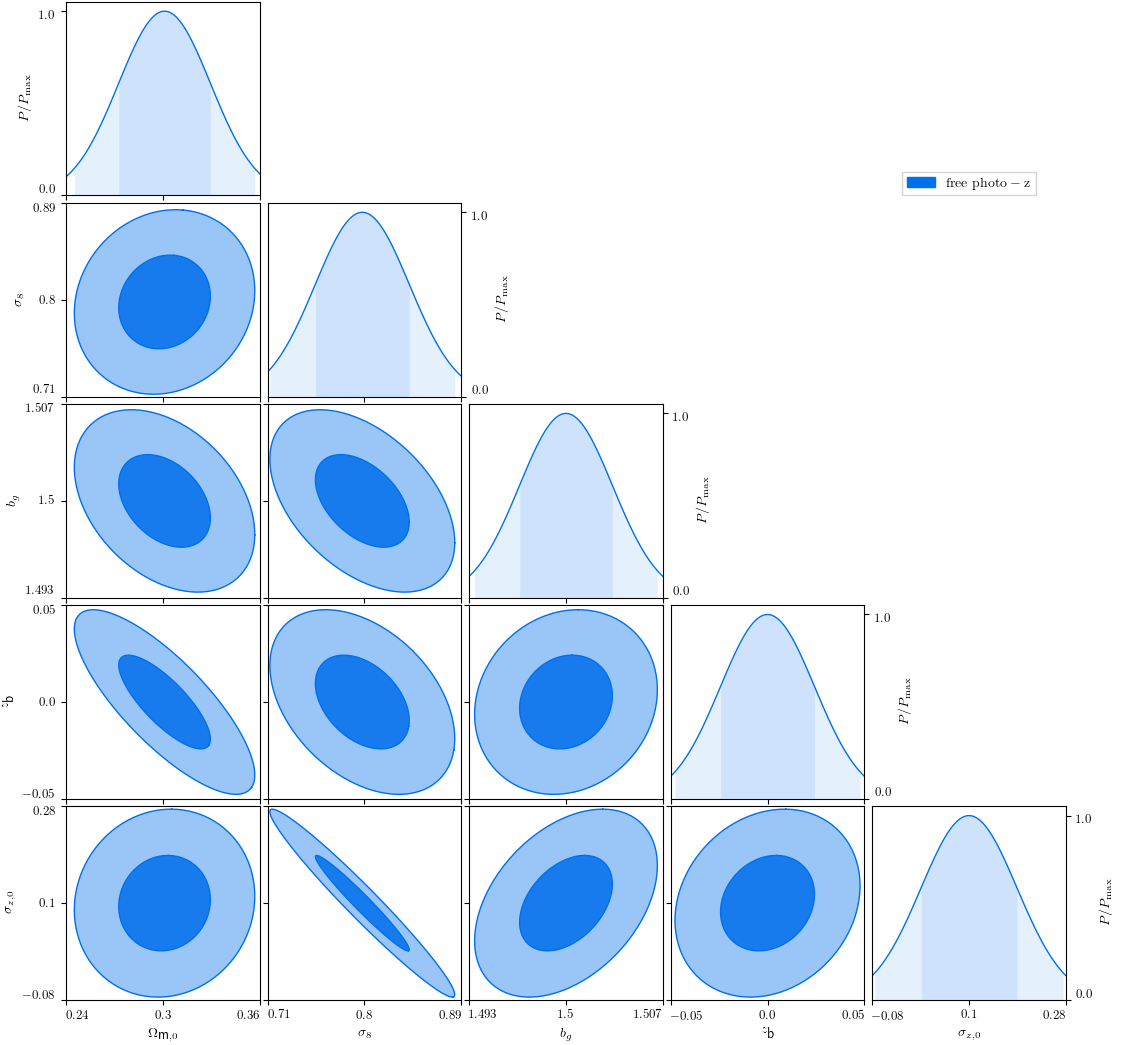

In [60]:
param_names = ['$\Omega_{\mbox{m},0}$', '$\sigma_8$', '$b_g$','$z_{\mbox{b}}$', '$\sigma_{z,0}$']

fiducial = [0.301, 0.798, 1.5, 0.0, 0.1]

fisher = fm.fisher_matrix(fisher_matrix=matrix, fiducial = fiducial, param_names=param_names )
fisher.name = 'free photo-z'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('free_phot.pdf', dpi=100)
fisher_plotter.export('free_phot.png', dpi=100)
IPython.display.Image(filename='free_phot.png',unconfined=True)

In [61]:
print(Fisher)

[[   8872.97933432   24780.23174437   52009.50921868   18168.69109562
     9925.4767814 ]
 [  24780.23174437  295380.92497006  334586.734286    140118.84827933
   128351.56694116]
 [  52009.50921868  334586.734286    568978.78985595  180418.21488953
   140865.6405201 ]
 [  18168.69109562  140118.84827933  180418.21488953   74276.76659778
    60015.82527113]
 [   9925.4767814   128351.56694116  140865.6405201    60015.82527113
    56029.86666667]]
